In [19]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
lfw = datasets.fetch_lfw_people(min_faces_per_person=100, resize=0.4)

In [3]:
lfw.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
lfw.data.shape, lfw.images.shape

((1140, 1850), (1140, 50, 37))

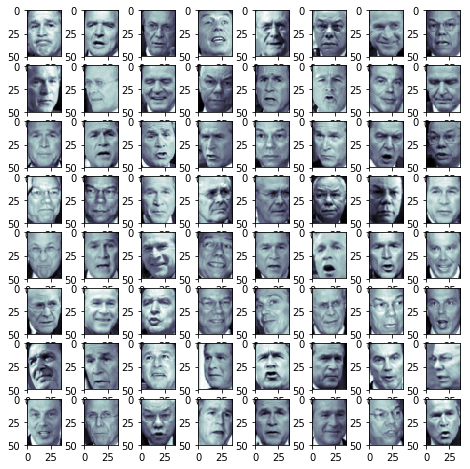

In [5]:
fig = plt.figure(figsize=(8, 8))
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(lfw.images[i], cmap= plt.cm.bone)
plt.show()

In [6]:
x, y = lfw.data, lfw.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((855, 1850), (855,), (285, 1850), (285,))

In [7]:
pca_oliv = PCA()
pca_oliv.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
k = 0
total = 0
while total < 0.99:
    total += pca_oliv.explained_variance_ratio_[k]
    k += 1
k

316

In [9]:
pca_lfw = PCA(n_components = k, whiten=True)
x_transformed = pca_lfw.fit_transform(x_train)
x_transformed.shape

(855, 316)

In [10]:
x_approx = pca_lfw.inverse_transform(x_transformed)
x_approx = x_approx.reshape((855, 50, 37))

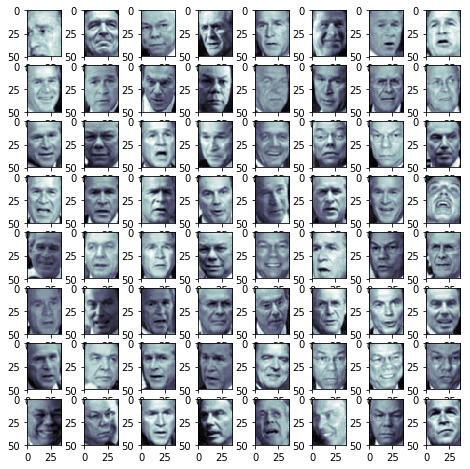

In [11]:
fig = plt.figure(figsize=(8, 8))
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(x_approx[i], cmap= plt.cm.bone)
plt.show()

In [12]:
eigenv = pca_lfw.components_
eigenv.shape

(316, 1850)

In [13]:
eigenfaces = eigenv.reshape((k, 50, 37))

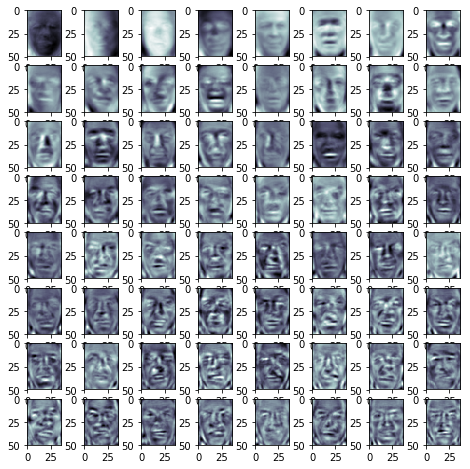

In [14]:
fig = plt.figure(figsize= (8, 8))
# plot 64 images
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(eigenfaces[i], cmap=plt.cm.bone)
plt.show()

In [15]:
x_train_pca = x_transformed
x_test_pca = pca_lfw.transform(x_test)

In [17]:
# without PCA 
rf = RandomForestClassifier()
start = time.time()
rf.fit(x_train, y_train)
end = time.time()
print('Time: ', end-start)
y_pred = rf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Time:  1.5867414474487305
             precision    recall  f1-score   support

          0       0.61      0.64      0.62        61
          1       0.56      0.39      0.46        36
          2       0.61      0.89      0.72       122
          3       0.80      0.13      0.22        31
          4       0.58      0.20      0.30        35

avg / total       0.62      0.61      0.56       285

[[ 39   1  21   0   0]
 [  6  14  14   0   2]
 [  8   3 109   0   2]
 [  5   4  17   4   1]
 [  6   3  18   1   7]]


In [18]:
# with PCA 
rf = RandomForestClassifier()
start = time.time()
rf.fit(x_train_pca, y_train)
end = time.time()
print('Time: ', end-start)
y_pred = rf.predict(x_test_pca)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Time:  0.13425850868225098
             precision    recall  f1-score   support

          0       0.43      0.39      0.41        61
          1       0.14      0.06      0.08        36
          2       0.54      0.85      0.66       122
          3       0.40      0.06      0.11        31
          4       0.19      0.09      0.12        35

avg / total       0.41      0.47      0.41       285

[[ 24   5  28   1   3]
 [  9   2  22   1   2]
 [ 11   1 104   0   6]
 [  8   3  16   2   2]
 [  4   3  24   1   3]]


In [22]:
# finding good parameters for SVM
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [24]:
# for SVM
clf = SVC()
grid = {"C":[1e2, 1e3, 1e4, 5e3, 5e4, 1e5], 'gamma':[1e-2, 1e-3, 1e-4, 5e-4, 5e-3]}
abc_svm = GridSearchCV(clf, grid)
abc_svm.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [100.0, 1000.0, 10000.0, 5000.0, 50000.0, 100000.0], 'gamma': [0.01, 0.001, 0.0001, 0.0005, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
abc_svm.best_estimator_

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
# using SVM --> without PCA
clf = SVC(C=100, gamma=0.01)
start = time.time()
clf.fit(x_train, y_train)
end = time.time()
print('Time: ', end-start)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(clf.score(x_test, y_test))

Time:  4.176907539367676


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        61
          1       0.00      0.00      0.00        36
          2       0.43      1.00      0.60       122
          3       0.00      0.00      0.00        31
          4       0.00      0.00      0.00        35

avg / total       0.18      0.43      0.26       285

[[  0   0  61   0   0]
 [  0   0  36   0   0]
 [  0   0 122   0   0]
 [  0   0  31   0   0]
 [  0   0  35   0   0]]
0.4280701754385965


In [28]:
# for SVM
clf = SVC()
grid = {"C":[1e2, 1e3, 1e4, 5e3, 5e4, 1e5], 'gamma':[1e-2, 1e-3, 1e-4, 5e-4, 5e-3]}
abc_svm = GridSearchCV(clf, grid)
abc_svm.fit(x_train_pca, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [100.0, 1000.0, 10000.0, 5000.0, 50000.0, 100000.0], 'gamma': [0.01, 0.001, 0.0001, 0.0005, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
abc_svm.best_estimator_

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
# using SVM --> with PCA
clf = SVC(C=100, gamma=0.0005)
start = time.time()
clf.fit(x_train_pca, y_train)
end = time.time()
print('Time: ', end-start)
y_pred = clf.predict(x_test_pca)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(clf.score(x_test_pca, y_test))

Time:  0.4852001667022705
             precision    recall  f1-score   support

          0       0.81      0.89      0.84        61
          1       0.86      0.69      0.77        36
          2       0.88      0.94      0.91       122
          3       0.88      0.68      0.76        31
          4       0.85      0.83      0.84        35

avg / total       0.86      0.86      0.85       285

[[ 54   2   1   1   3]
 [  4  25   6   0   1]
 [  4   1 115   2   0]
 [  3   1   5  21   1]
 [  2   0   4   0  29]]
0.856140350877193
